In [1]:
# import torch

# reward_model_path = "CartPole-v1_reward_model_seed42.pth"

# reward_model = torch.load(reward_model_path, map_location="cpu")
# reward_model.eval()
# reward_model.to("cpu")



C:\Users\MATH-286-Dell\AppData\Local\Temp\ipykernel_24764\3126179007.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  reward_model.load_state_dict(torch.load(reward_mode

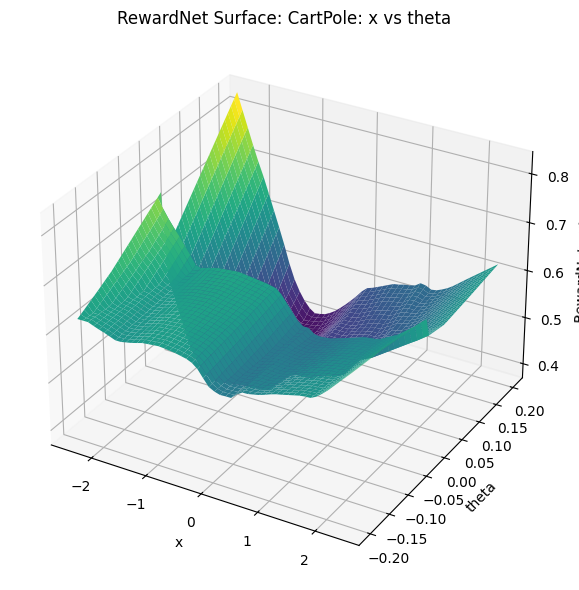

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import gymnasium as gym

def plot_reward_surface(env_id, reward_model_path, is_discrete, device="cpu", n_points=50):
    # 加载环境
    env = gym.make(env_id)
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.n if is_discrete else env.action_space.shape[0]

    # 加载 reward_model
    class RewardNet(torch.nn.Module):
        def __init__(self, obs_dim, act_dim, is_discrete=True, hidden_size=64):
            super().__init__()
            self.obs_dim = obs_dim
            self.act_dim = act_dim
            self.is_discrete = is_discrete
            self.net = torch.nn.Sequential(
                torch.nn.Linear(obs_dim + act_dim, hidden_size),
                torch.nn.ReLU(),
                torch.nn.Linear(hidden_size, 1)
            )
        def forward(self, states, actions):
            if self.is_discrete:
                one_hot = torch.nn.functional.one_hot(actions.view(-1), num_classes=self.act_dim).float()
                x = torch.cat([states, one_hot], dim=-1)
            else:
                x = torch.cat([states, actions], dim=-1)
            return self.net(x).squeeze(-1)

    reward_model = RewardNet(obs_dim, act_dim, is_discrete)
    reward_model.load_state_dict(torch.load(reward_model_path, map_location=device))
    reward_model.eval()
    reward_model.to(device)

    # 选择可视化的状态变量
    if env_id.startswith("CartPole"):
        # CartPole: obs = [x, x_dot, theta, theta_dot]
        x_range = np.linspace(-2.4, 2.4, n_points)
        theta_range = np.linspace(-0.2, 0.2, n_points)
        X, Y = np.meshgrid(x_range, theta_range)
        obs = np.zeros((n_points * n_points, obs_dim), dtype=np.float32)
        obs[:, 0] = X.ravel()      # x
        obs[:, 2] = Y.ravel()      # theta
        # 其他状态设为0
        if is_discrete:
            actions = torch.arange(act_dim).repeat_interleave(n_points * n_points // act_dim + 1)[:n_points * n_points]
        else:
            actions = np.zeros((n_points * n_points, act_dim), dtype=np.float32)
        title = "CartPole: x vs theta"
    elif env_id.startswith("Pendulum"):
        # Pendulum: obs = [cos(theta), sin(theta), theta_dot]
        theta_range = np.linspace(-np.pi, np.pi, n_points)
        theta_dot_range = np.linspace(-2, 2, n_points)
        X, Y = np.meshgrid(theta_range, theta_dot_range)
        obs = np.zeros((n_points * n_points, obs_dim), dtype=np.float32)
        obs[:, 0] = np.cos(X.ravel())
        obs[:, 1] = np.sin(X.ravel())
        obs[:, 2] = Y.ravel()
        if is_discrete:
            actions = torch.zeros(n_points * n_points, dtype=torch.long)
        else:
            actions = np.zeros((n_points * n_points, act_dim), dtype=np.float32)
        title = "Pendulum: theta vs theta_dot"
    else:
        raise NotImplementedError("Only CartPole and Pendulum are supported for visualization.")

    # 计算 reward
    obs_tensor = torch.tensor(obs, dtype=torch.float32, device=device)
    if is_discrete:
        actions_tensor = actions.to(device)
    else:
        actions_tensor = torch.tensor(actions, dtype=torch.float32, device=device)
    with torch.no_grad():
        rewards = reward_model(obs_tensor, actions_tensor).cpu().numpy()
    rewards = rewards.reshape(n_points, n_points)

    # 画图
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, rewards, cmap='viridis')
    ax.set_title(f"RewardNet Surface: {title}")
    if env_id.startswith("CartPole"):
        ax.set_xlabel("x")
        ax.set_ylabel("theta")
    else:
        ax.set_xlabel("theta")
        ax.set_ylabel("theta_dot")
    ax.set_zlabel("RewardNet output")
    plt.tight_layout()
    plt.show()

# 用法示例（请根据实际路径和环境类型填写）：
plot_reward_surface("CartPole-v1", "CartPole-v1_reward_model_seed42.pth", is_discrete=True)

C:\Users\MATH-286-Dell\AppData\Local\Temp\ipykernel_24764\3126179007.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  reward_model.load_state_dict(torch.load(reward_mode

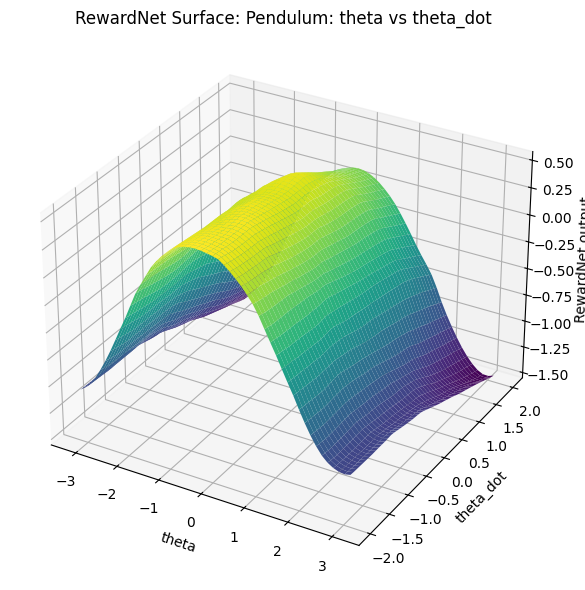

In [5]:
plot_reward_surface("Pendulum-v1", "Pendulum-v1_reward_model_seed42.pth", is_discrete=False)

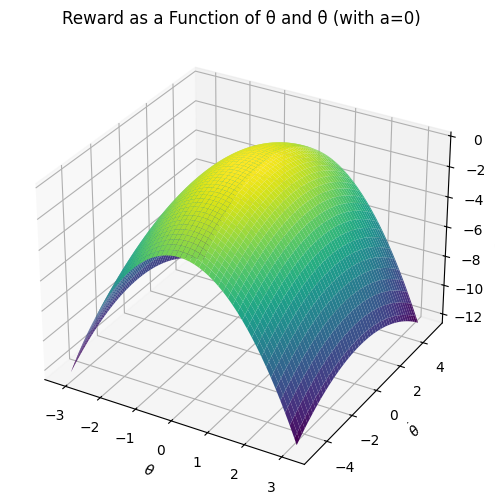

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the ranges for theta and theta_dot
theta = np.linspace(-np.pi, np.pi, 100)
theta_dot = np.linspace(-5, 5, 100)
Theta, Theta_dot = np.meshgrid(theta, theta_dot)

# Use a fixed action a = 0 for plotting the reward surface over (theta, theta_dot)
a = 0.0
Reward = -(Theta**2 + 0.1 * Theta_dot**2 + 0.001 * a**2)

# Plotting
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Theta, Theta_dot, Reward, cmap='viridis', edgecolor='none')

ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\dot{\theta}$')
ax.set_zlabel('Reward')
ax.set_title('Reward as a Function of θ and θ̇ (with a=0)')

plt.show()
